<h1>Техническое задание</h1>

<h2>Теоретическая часть</h2>

Для документа $d$ оценим вероятность $P(c|d)$ его принадлежности к классу $c$. По теореме Байеса $$P(c|d) = \frac{P(d|c)P(c)}{P(d)}.$$

Тогда "наиболее вероятным" классом будет $$\hat c = \arg \max_{c \in C} \frac{P(d|c)P(c)}{P(d)} = \arg \max_{c \in C} P(d|c)P(c).$$ 


Предполагаем, что $P(d|c) \approx P(w_1|c)P(w_2|c)\dots P(w_n|c) = \Pi_{i=1}^{n}P(w_i|c)$, тогда $$\hat c = \arg \max_{c \in C} \left(P(c) \Pi_{i=1}^{n}P(w_i|c)\right).$$
Чтобы избежать перемножения большого количества маленьких чисел, применяют $\log$. В силу монотонности данной функции, значение $c$, при котором достигается максимум функции правдоподобия, не изменится. Поэтому
$$\hat c = \arg \max_{c \in C} \left(\log P(c) +  \sum_{i=1}^{n}\log P(w_i|c)\right).$$

Оценим вероятность $P(c) = \frac{D_c}{D}$, где $D_c$ - количество документов класса $c$, $D$ - количество документов. Условную вероятность $P(w_i|c)$ можно оценивать по-разному. 

* В мультиномиальной модели $P(w_i|c) = \frac{W_{ic}}{\sum_{i' \in V} W_{i'c}}$, где $W_{ic}$ - суммарное количество раз, которое $i$-е слово встречается в документах класса $c$. Знаменатель, на самом деле - суммарное количество слов во всех документах класса $c$. Обозначим его $L_c = \sum_{i' \in V} W_{i'c}$.

* Вторым подходом к оцениванию $P(w_i|c)$ является бернуллиевская модель, которая будет рассмотрена в части 2.

<h4>Проблема неизвестных слов</h4>

Если при предсказании метки класса нам встречается слово, которого не было в обучающей выборке, то  $\Pi_{i=1}^{n}P(w_i|c) = 0,\ \forall c$. Таким образом, мы не сможем классифицировать текст с данным словом.

Существует несколько методов заполнения пропусков. Первый из них - <i>сглаживание Лапласа</i>
$$P(w_i|c) = \frac{W_{ic} + \alpha}{\sum_{i' \in V} (W_{i'c}+ \alpha)} = \frac{W_{ic} + \alpha}{\alpha|V| + \sum_{i' \in V} W_{i'c}} = \frac{W_{ic} + \alpha}{\alpha|V| + L_c},\ \alpha \in (0, 1].$$

Тогда классификация производится как

$$\hat c = \arg \min_{c \in C} \log\frac{D_c}{D}  + \sum_{i \in Q} \log \frac{W_{ic} + \alpha}{\alpha|V| + L_c}.$$

В первой части используется сглаживание Лапласа с параметром $\alpha = 1$. Другие методы заполнения пропусков будут рассмотрены в части 2.

<h2>Часть 1</h2>

Импорт необходимых библиотек.

In [1]:
import os
import re
import operator
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import StratifiedKFold, cross_val_score

<h3>Мультиномиальный наивный байесовский классификатор</h3>

В данной реализации названиям переменных соответствуют обозначения, принятые в теоретической части.

In [27]:
class MultinomialNB(object):
    """Multinomial Naive Bayes Model class."""

    def __init__(self):
        self.D = 0
        self.V = 0
        self.Dc = dict()
        self.Lc = dict()
        self.Wc = dict()
        self.labels = set()
       
    def fit(self, X, y):
        """Fit model parameters given documents(list representation) and labels."""
        self.D = X.shape[0]
        self.labels = set(y)
        self.V = np.sum([np.sum(X, axis=0) > 0])
        for label in self.labels:
            self.Dc[label] = len(y[y==label])
            wc = np.sum(X[y==label, :], axis=0)
            self.Wc[label] = wc
            self.Lc[label] = np.sum(wc)

    def good_turing(self):
        """Apply good-turing smoothing to Wc matrix."""
        newWc = dict()
        for label in self.labels:
            Nc = []
            w = self.Wc[label]
            newWc[label] = []
            for i in xrange(1, np.max(w)+1):
                Nc.append(len(w[w == i]))
            for i, val in enumerate(w):
                if val == 0:
                    newWc[label].append(Nc[0] / float(np.sum(w)))
                else:
                    if val < len(Nc):
                        newWc[label].append((val + 1.) * Nc[val] / Nc[val-1])
                    else:
                        newWc[label].append(val + 1.)
            newWc[label] = np.array(newWc[label])
        return newWc       
            
    def predict(self, X, method='laplace', alpha=1.):
        """Predict class values."""
        predicted_y = []    
        if method == 'laplace':
            Wc = self.Wc
        elif method == 'good-turing':
            Wc = self.good_turing()
        for i in xrange(X.shape[0]):
            val = dict()
            for label in self.labels:
                fval = np.sum(X[i, :] * (np.log(Wc[label] + alpha) - np.log(alpha * self.V + self.Lc[label])))
                val[label] = fval + np.log(self.Dc[label] / (self.D + 0.))
            predicted_y.append(max(val.iteritems(), key=operator.itemgetter(1))[0])
        return np.array(predicted_y)

<h4>Игрушечный пример</h4>

In [3]:
documents = [
    'предоставляю услуги бухгалтера',
    'спешите купить смартфон',
    'надо купить молоко',
    'надо купить батон',
]

y = np.array([1, 1, 0])
vc = CountVectorizer()
X = vc.fit_transform(documents)
X= X.toarray()
nb = MultinomialNB()
nb.fit(X[:3, :], y)
c  = nb.predict(X[3:, :], method='laplace', alpha=1)
print c

[0]


<h4>Датасет bare</h4>

Посмотрим, как алгоритм сработает на реальных данных. Подготовим коллекцию из папки lingspam_public/bare/.

In [4]:
def prepareCollection(dir_address):
    """Return list of texts and list of labels given directory address."""
    dirs = os.listdir(dir_address)
    files = dict()
    for dir in dirs:
        files[dir] = os.listdir(dir_address + dir)
    documents = []
    labels = []
    for dir in files:
        for file in files[dir]:
            if file[0:5] == 'spmsg':
                labels.append(1) # spam labeled as 1
            else:
                labels.append(0)
            with open(dir_address + dir + '/' + file, 'r') as f:
                document = f.read()
            documents.append(document)
    return (np.array(documents), np.array(labels))

Посмотрим, сколько в коллекции документов класса "спам".

In [6]:
documents, labels = prepareCollection('lingspam_public/bare/')
np.mean(labels) * 100

16.626339440027653

Видно, что доля спам-документов в каждой директории равна приблизительно 16.6%.

Сравним качества работы реализованного выше алгоритма с его библиотечной версией MultinomialNB. Для подсчета частот слов используется CountVectorizer, с помощью которого вычисляется матрица $X$ размера $D \times V$, где $D$ - количество документов коллекции, а $V$ - размер словаря, причем $D_{ij}$ - количество раз, которое $j$-е слово из словаря встречается в $i$-м документе. За $y$ обозначим метки классов документов: 1 - спам, 0 - не спам.

Я объединил документы всех директорий, и то, как хорошо разбивается коллекция на обучающую и тестовую выборки, зависит от класса StratifiedKFold из библиотеки sklearn , который, согласно http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html, сохраняет долю объектов каждого класса при разбиении.

In [7]:
y = labels
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

Реализуем функции, позволяющие оценить качество работы алгоритма классификации.

In [17]:
def classification_score(y_test, y_predicted, scoring='precision'):
    """Get classification score given predicted labels and test labels."""
    tp, fp, fn = 0, 0, 0
    for i, score in enumerate(y_predicted):

        if y_test[i] == 1 and score == 0:
            fn += 1
        elif y_test[i] == 0 and score == 1:
            fp += 1
        elif y_test[i] == 1 and score == 1:
            tp += 1

    precision = tp / (tp + fp + 1.e-15)
    recall = tp / (tp + fn + 1.e-15)
    if scoring == 'accuracy':
        N = len(y_test)
        P = N - fp - fn
        return (P + 0.) / N
    elif scoring == 'precision':
        return precision
    elif scoring == 'recall':
        return recall
    elif scoring == 'f1':
        return 2 * (precision * recall) / (precision + recall + 1.e-15)
        
def plotScores(scores, n_folds):
    plt.figure(figsize=(10, 8))
    plt.xlabel(r'$k$', fontsize=15)
    plt.ylabel(r'$F_1$', fontsize=15)
    for key, score in scores.items():
        plt.plot(n_folds, np.array(score), label=key)
    plt.legend()

Существует несколько различных метрик качества классификации.


* accuracy - отношение количества правильно классифицированных документов $P$ к количеству всех документов $N$
$$accuracy = \frac{P}{N}.$$
Заметим, что если в тестовой и обучающей выборке больше объектов класса 1, то, срабатывая плохо на объектах класса 0, алгоритм будет все равно иметь высокую accuracy в силу того, что объектов класса 0 мало. Таким образом, данная метрика недостаточно хорошо измеряет качество работы алгоритма классификации, и на нее мы не будем обращать особого внимания.




* precision - это доля документов действительно принадлежащих данному классу относительно всех документов, которые алгоритм отнес к этому классу

$$precision = \frac{tp}{tp + fp}.$$

* recall - доля найденных классификатором документов принадлежащих данному классу относительно всех документов этого класса в тестовой выборке

$$recall = \frac{tp}{tp + fn}$$


* $f_1$-мера - "баланс" между precision и recall
$$f_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}.$$

Выбор какой-то одной метрики удобен для сравнения работы алгоритмов. Как указано выше, accuracy не является хорошей метрикой, в особенности, для нашей коллекции, так как доля спам-сообщений меньше доли обычных сообщений. Мера $f_1$ объединяет метрики precision и recall, поэтому она и используется для измерения качества классификации.

In [11]:
mynb = MultinomialNB()
nb = naive_bayes.MultinomialNB()
scores = {'myNB':[], 'NB': []}
for n in range(2, 11):
    skf = StratifiedKFold(y, n_folds=n)
    print n,
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        mynb_score = []
        mynb.fit(X_train.toarray(), y_train)
        mynb_pred = mynb.predict(X_test.toarray())
        mynb_score.append(classification_score(y_test, mynb_pred))
        
        nb_score = []
        nb.fit(X_train, y_train)
        nb_pred = nb.predict(X_test)
        nb_score.append(classification_score(y_test, nb_pred))

    scores['myNB'].append(np.mean(mynb_score))
    scores['NB'].append(np.mean(nb_score))

2 3 4 5 6 7 8 9 10


График зависимости качества классификации от $k$ для обеих реализаций.

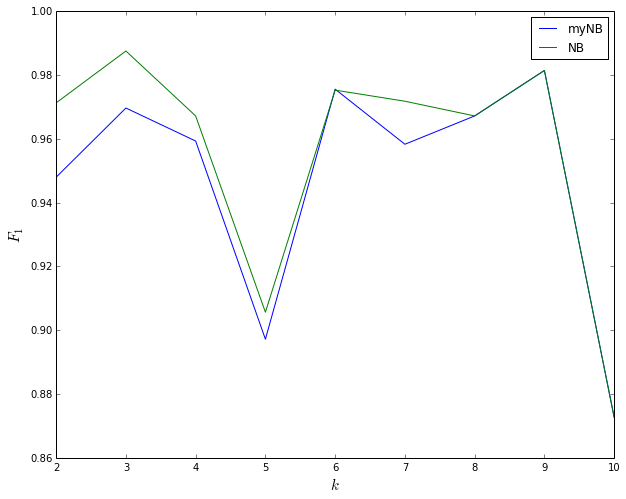

In [12]:
plotScores(scores, range(2, 11))

Видно, что по $f_1$-мере обе реализации показывают схожее качество классификации.

Ниже приведена зависимость от $k$ качества классификации алгоритмом MultinomialNB для различных метрик качества.

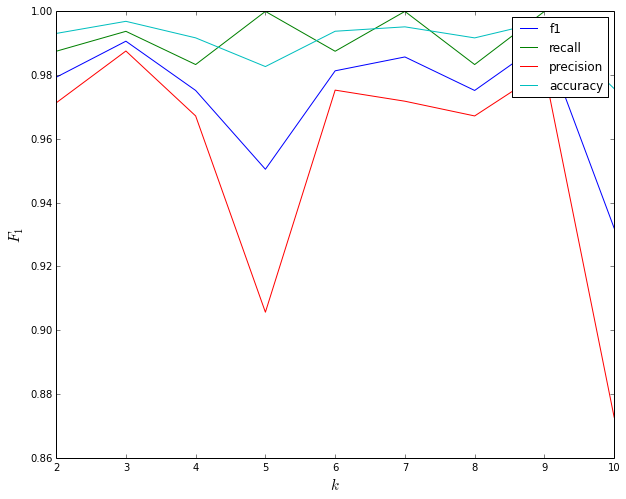

In [13]:
n_folds = range(2, 11)
scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
plt.figure(figsize=(10, 8))
for n in n_folds:
    skf = StratifiedKFold(y, n_folds=n)
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    nb.fit(X_train, y_train)
    y_predicted = nb.predict(X_test)
    for method in scores.keys():
        scores[method].append(classification_score(y_test, y_predicted, scoring=method))
plotScores(scores, n_folds)

<h2>Часть 2</h2>

In [239]:
nb = naive_bayes.MultinomialNB()
vectorizer = CountVectorizer()

<h3>Лемматизация и исключение стоп-слов</h3>

В нашем bag-of-words подходе нет смысла рассматривать разные формы одного и того же слова - от порядка слов в документе ничего не зависит. Стоп-слова также несут мало информации о принадлежности к классу, поэтому их устранение также помочь в классификации. Посмотрим, как изменится качество классификации, если мы будем использовать
* коллекцию без стоп-слов (слова "a", "the", "and" и т.д.),
* коллекцию, где все слова приведены к начальной форме (глагол "am" приведен к форме "be", например),
* коллекцию, где нет стоп-слов и все слова приведены к начальной форме.

 lingspam_public/lemm/ lingspam_public/stop/ lingspam_public/lemm_stop/


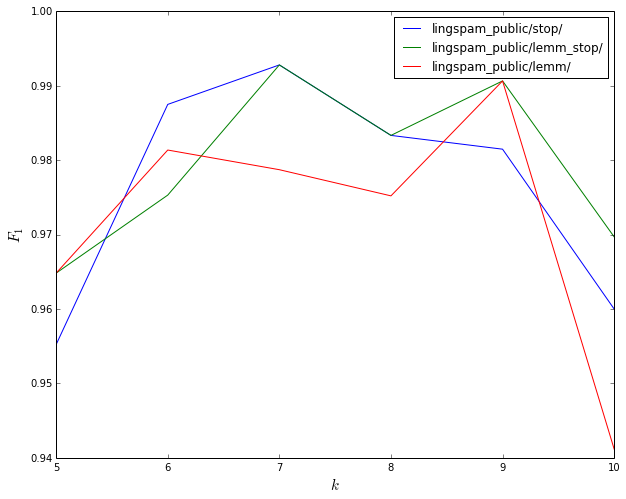

In [243]:
dirs = ['lingspam_public/lemm/', 'lingspam_public/stop/', 'lingspam_public/lemm_stop/']
scores = dict()
for dir in dirs:
    print dir, 
    scores[dir] = []
    documents, labels = prepareCollection(dir)
    y = np.array(labels)
    X = vectorizer.fit_transform(documents)
    n_folds = range(5, 11)
    for n in n_folds:
        skf = StratifiedKFold(y, n_folds=n)
        for train_index, test_index in skf:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        nb.fit(X_train, y_train)
        y_predicted = nb.predict(X_test)
        scores[dir].append(classification_score(y_test, y_predicted, scoring='f1'))
plotScores(scores, n_folds)

Из графика видно, что в $f_1$-мере лемматизация и устранение стоп-слов дает прирост в качестве классификации при $k > 8.$ Таким образом, уместно в вычислениях использовать коллекцию lemm_stop.

<h3>Бернуллиевский наивный байесовский классификатор</h3>

В данной модели текст представляет собой вектор $\vec{d} \in \{0, 1\}^n$, где $d_j = 1$, если $j$-е слово из словаря $V$ присутствует в тексте, $d_j = 0$ иначе. Тогда 
$$P(d|c) \approx P(\vec{d}|c) = \Pi_{j=1}^{|V|} \left(d_j \cdot P(w_j|c) + (1 - d_j)\cdot(1 - P(w_j|c)\right).$$

Можно представлять себе $\vec{d}$ из класса $c$ как результат $|V|$ подбрасываний $n$ асимметричных монет, причем $j$-я монета падает орлом с вероятностью $P(w_j|c).$

Вероятность $P(c)$ оцениваем как долю документов класса $c$ среди всех документов обучающей выборки
$$P(c) = \frac{N_c}{N}.$$

Вероятность появления $j$-го слова из словаря $V$ в документе класса $c$ оцениваем отношением количества документов класса $c$, содержащих слово $w_j$ к количеству документов класса $c$
$$P(w_j|c) = \frac{n^j_c}{ N_c}.$$

Как и в случае мультиномиального наисвного байесовского классификатора, берется логарифм от $P(c|d)$ для того, чтобы избежать перемножения большого количества малых чисел. Тогда

$$\hat c = \arg \min_{c \in C}   \sum_{j =1}^{|V|} \log \left(d_j \cdot \frac{n^j_c}{ N_c} + (1 - d_j)\cdot(1 - \frac{n^j_c}{ N_c})\right) + \log \frac{N_c}{N}.$$

Естественно, если в документе из тестовой выборки встречается слово, которого не было в обучающей выборке, мы не сможем классифицировать данный документ, т.к. $d_j = 1$, а $n^j_c = 0.$ Поэтому производится сглаживание  
$$P(w_j|c) = \frac{n^j_c + \alpha}{ N_c + \alpha \cdot |V|}.$$

In [475]:
class BernoulliNB(object):
    """Bernoulli Naive Bayes Model."""

    def __init__(self, alpha=1):
        self.N = 0
        self.Nc = dict()
        self.nc = dict()
        self.labels = set()
       
    def fit(self, X, y):
        """Fit model parameters given documents(list representation) and labels."""
        X = X.toarray()
        self.N = X.shape[0]
        self.labels = set(y)
        for label in self.labels:
            self.Nc[label] = len(y[y==label])
            self.nc[label] = np.sum(X[y==label, :], axis=0) 
            
    def predict(self, X, alpha=0.03):
        """Predict class values."""
        predicted_y = []
        X = X.toarray()
        V = X.shape[1]
        for i in xrange(X.shape[0]):
            val = dict()
            for label in self.labels:
                pc = (self.nc[label] + alpha) / float(self.Nc[label] + alpha * V)
                fval = np.sum(np.log(X[i, :] * pc + (1. - X[i, :]) * (1. - pc)))
                val[label] = fval + np.log(self.Nc[label] / float(self.N))
            predicted_y.append(max(val.iteritems(), key=operator.itemgetter(1))[0])
        return np.array(predicted_y)

Сравним данную реализацию с реализацией из библиотеки sklearn.

In [478]:
mynb = BernoulliNB()
nb = naive_bayes.BernoulliNB(alpha=0.03)
vectorizer = CountVectorizer(binary=True)

Построим зависимость качества классификации от k_folds для этих двух реализаций.

5 6 7 8 9 10


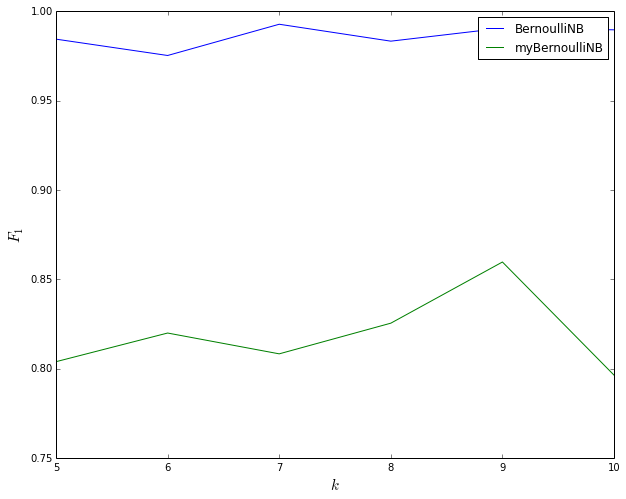

In [479]:
scores = {'myBernoulliNB': [], 'BernoulliNB': []}
documents, labels = prepareCollection('lingspam_public/lemm/')
y = np.array(labels)
X = vectorizer.fit_transform(documents)
n_folds = range(5, 11)
for n in n_folds:
    print n,
    skf = StratifiedKFold(y, n_folds=n)
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    nb.fit(X_train, y_train)
    nb_predicted = nb.predict(X_test)
    mynb.fit(X_train, y_train)
    mynb_predicted = mynb.predict(X_test)
    scores['BernoulliNB'].append(classification_score(y_test, nb_predicted, scoring='f1'))
    scores['myBernoulliNB'].append(classification_score(y_test, mynb_predicted, scoring='f1'))
plotScores(scores, n_folds)

Реализация из библиотеки sklearn показала лучшее качество. Судя по всему, там используется несколько иная техника сглаживания. Сравним библиотечные версии MultinomialNB и BernoulliNB между собой.

 5 6 7 8 9 10


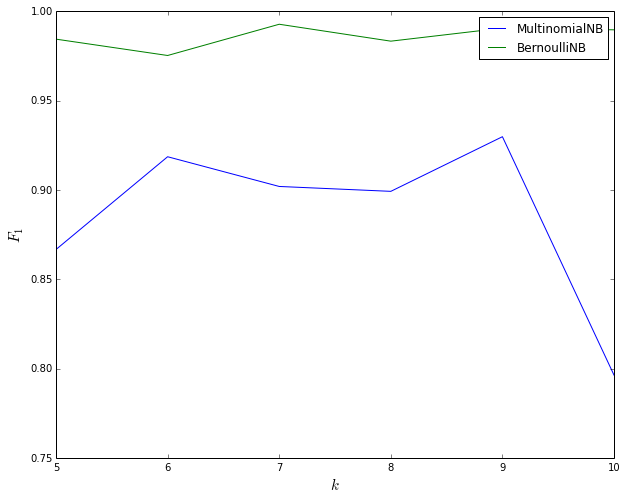

In [481]:
mnb = naive_bayes.MultinomialNB(alpha=0.03)
nb = naive_bayes.BernoulliNB(alpha=0.03)
vectorizer = CountVectorizer(binary=True)

scores = {'MultinomialNB': [], 'BernoulliNB': []}
documents, labels = prepareCollection('lingspam_public/lemm/')
y = np.array(labels)
X = vectorizer.fit_transform(documents)
n_folds = range(5, 11)
for n in n_folds:
    print n,
    skf = StratifiedKFold(y, n_folds=n)
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    nb.fit(X_train, y_train)
    nb_predicted = nb.predict(X_test)
    mnb.fit(X_train, y_train)
    mnb_predicted = mynb.predict(X_test)
    scores['BernoulliNB'].append(classification_score(y_test, nb_predicted, scoring='f1'))
    scores['MultinomialNB'].append(classification_score(y_test, mnb_predicted, scoring='f1'))
plotScores(scores, n_folds)

При малом параметре сглаживания $\alpha = 0.03$ алгоритм BernoulliNB показывает лучшее качество классификации. Возможно, это связано с длиной сообщений. Вычислим количество слов для каждого текста.

In [490]:
word_counts= []
bareAddress = 'lingspam_public/bare/'
dirs = os.listdir(bareAddress)
files = dict()
for dir in dirs:
    files[dir] = os.listdir(bareAddress + dir)
for dir in files:
    documents = []
    labels = []
    for file in files[dir]:
        counter = 0
        with open(bareAddress + dir + '/' + file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                for word in re.split('\W+', line):
                    new_word = word.lower()
                    if new_word != '':
                        counter += 1
        word_counts.append(counter)

Гистограмма распределения количества слов в сообщениях.

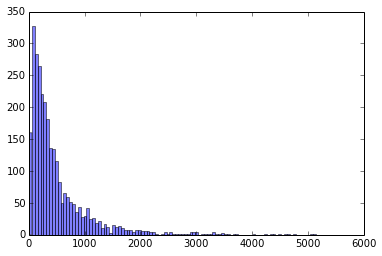

In [492]:
_=plt.hist(word_counts, alpha=0.5, bins = 100)

Действительно, большую часть сообщений составляют "короткие" сообщения, а алгоритм BernoulliNB, как известно, хорошо работает с короткими текстами.

<h3>N-граммная языковая модель</h3>

Ранее мы рассматривали bag-of-word модель документа. Что будет, если теперь мы будем рассматривать не вероятности $P(w|c)$ появления слова в документе класса $c$, а вероятности появления пары слов $P(w_aw_b|c)$? 

Кажется, что если мы обучим модель достаточным количеством пар слов, встречающихся в языке, то наша модель будет ближе к грамматике самого языка. 

Посмотрим, помогут ли нам биграммы в классификации спама.

2-gram
1-gram


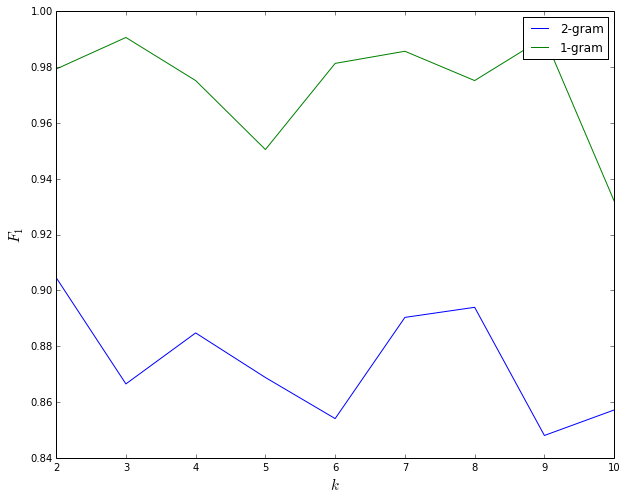

In [248]:
vectorizers = {'1-gram': CountVectorizer(), '2-gram': CountVectorizer(ngram_range=(2, 2))}
documents, labels = prepareCollection('lingspam_public/bare/')
nb = naive_bayes.MultinomialNB()
scores = dict()

for name, vectorizer in vectorizers.items():
    print name
    scores[name] = []
    y = np.array(labels)
    X = vectorizer.fit_transform(documents)
    n_folds = range(2, 11)
    for n in n_folds:
        skf = StratifiedKFold(y, n_folds=n)
        for train_index, test_index in skf:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        nb.fit(X_train, y_train)
        y_predicted = nb.predict(X_test)
        scores[name].append(classification_score(y_test, y_predicted, scoring='f1'))
plotScores(scores, n_folds)

Видно, на тестовой выборке качество классификации хуже для биграмной модели. Судя по всему, обучающая выборка недостаточно богата парами часто встречающихся рядом слов. Поэтому при появлении в тестовой выборке пары, которой не было в обучающей выборке, она получит маленькую вероятность, хотя, на самом деле, данная пара слов может встречаться в жизни довольно часто.

<h2>Литература</h2>
* http://scikit-learn.org
* http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf
* http://bazhenov.me/blog/2012/06/11/naive-bayes.html
* http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html